In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
# Import packages that will be used
import c2qa
import custom_gates.state_transfer
import custom_gates.qft
import numpy as np
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister,QuantumRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library.standard_gates import HGate
from math import pi, ceil
import scipy
from c2qa.operators import CVOperators
from c2qa.qumoderegister import QumodeRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from c2qa.parameterized_unitary_gate import ParameterizedUnitaryGate
from qiskit.quantum_info import hellinger_fidelity
from qutip import *

/home/smohapa5


In [23]:
n = 2
ancilla = 4
append = 2

In [28]:
cutoff = 2**3
delta = 0.29
delta_prime = (2*np.pi)/(np.pow(2,n+ancilla+append)*delta)
print(delta_prime)

0.08463342277989745


In [25]:
Ust = custom_gates.state_transfer.dv2cv_st_non_abelian(delta,n+ancilla+append,cutoff)
Ust1 = custom_gates.state_transfer.dv2cv_st_non_abelian(delta_prime,n+append+ancilla,cutoff)

In [5]:
F_gate = custom_gates.qft.F(cutoff)

In [26]:
def apply_basis_transformation(circuit, combined_register):
    """Apply basis transformation gates to a combined register.
    
    MSB: Apply H, X, Z gates.
    LSB: Apply H, Z gates.
    Others: Apply H, X gates.
    
    Args:
        circuit: The quantum circuit.
        combined_register: The combined register containing append, qubits, and ancilla.
    """
    num_qubits = len(combined_register)
    for i in range(num_qubits):
        circuit.h(combined_register[i])
        if i == 0:  # MSB
            circuit.x(combined_register[i])
            circuit.z(combined_register[i])
        elif i == num_qubits-1:  # LSB
            circuit.z(combined_register[i])
        else:  # Middle qubits
            circuit.x(combined_register[i])

def apply_reverse_basis_transformation(circuit, combined_register):
    """Apply reverse basis transformation gates to a combined register.
    
    MSB: Apply Z, X, H gates.
    LSB: Apply Z, H gates.
    Others: Apply X, H gates.
    
    Args:
        circuit: The quantum circuit.
        combined_register: The combined register containing append, qubits, and ancilla.
    """
    num_qubits = len(combined_register)
    for i in range(num_qubits):
        if i == num_qubits-1:  # LSB
            circuit.z(combined_register[i])
            circuit.h(combined_register[i])
        elif i == 0:  # MSB
            circuit.z(combined_register[i])
            circuit.x(combined_register[i])
            circuit.h(combined_register[i])
        else:  # Middle qubits
            circuit.x(combined_register[i])
            circuit.h(combined_register[i])

1.172236064772311


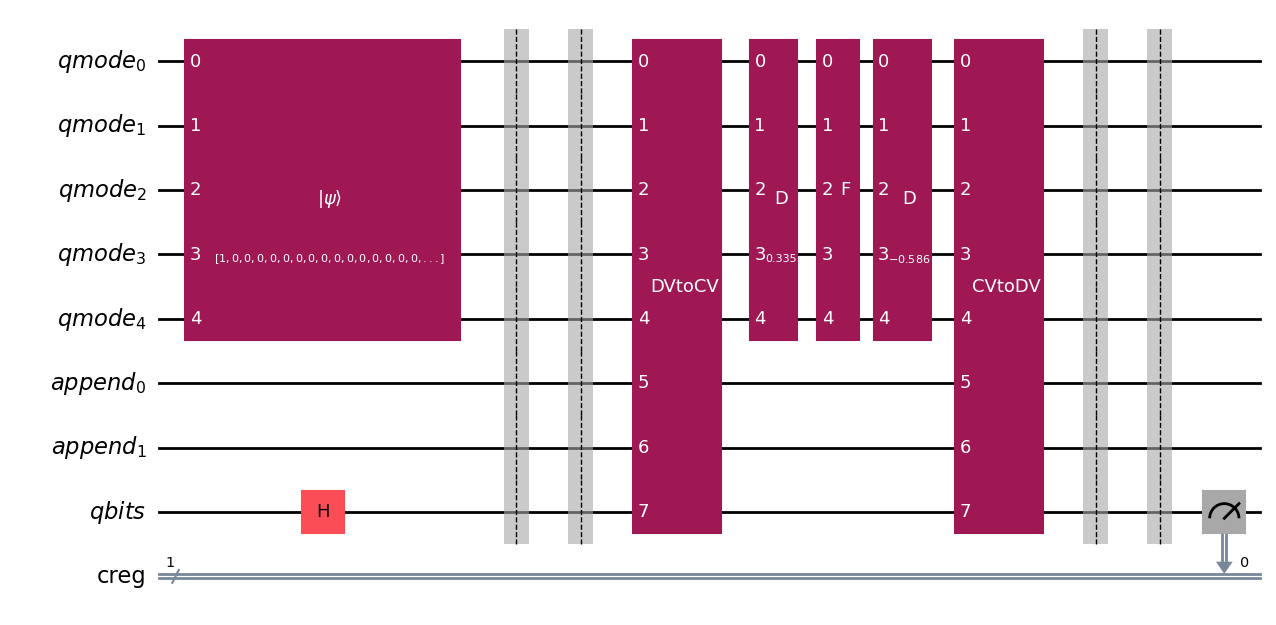

In [60]:
n = 1
ancilla = 0
append = 2

cutoff = 2**5
delta = 0.67
delta_prime = (2*np.pi)/(np.pow(2,n+ancilla+append)*delta)
print(delta_prime)

Ust = custom_gates.state_transfer.dv2cv_st_non_abelian(delta,n+ancilla+append,cutoff)
Ust1 = custom_gates.state_transfer.dv2cv_st_non_abelian(delta_prime,n+append+ancilla,cutoff)

F_gate = custom_gates.qft.F(cutoff)

qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=5, name='qmode')
qbr1 = QuantumRegister(n,name='qbits')
ancilla_reg = QuantumRegister(ancilla,name = 'ancilla')
append_reg = QuantumRegister(append, name='append')
cr1 = ClassicalRegister(1, name='creg')
circuit = c2qa.CVCircuit(qmr, append_reg, qbr1, ancilla_reg, cr1)

# Combine append, qubits, and ancilla registers
total_register = append_reg[:]+ qbr1[:] + ancilla_reg[:]

# Initialization
circuit.cv_initialize(0, qmr[0])

circuit.h(qbr1[0])
circuit.barrier()

# Basis transformation
# apply_basis_transformation(circuit, total_register)

circuit.barrier()

# CV gates and operations
gate1 = UnitaryGate(Ust.full(), label='DVtoCV')
circuit.append(gate1, qmr[:] + total_register)
circuit.cv_d(delta / 2, qmr[0])

gate2 = UnitaryGate(F_gate.full(), label='F')
circuit.append(gate2, qmr[:])

circuit.cv_d(-delta_prime / 2, qmr[0])

gate3 = UnitaryGate(Ust1.dag().full(), label='CVtoDV')
circuit.append(gate3, qmr[:] + total_register)

circuit.barrier()

# Reverse basis transformation
# apply_reverse_basis_transformation(circuit, total_register)

circuit.barrier()

# Measurements
# for i, qubit in enumerate(total_register):
#     if(i == 0 or i ==1):
#         continue
#     if(i>1 and i<=n+1):
#         circuit.measure(qubit, cr1[-(i + 1)])
# circuit.measure(ancilla_reg[1], cr1[0])
circuit.measure(qbr1[0], cr1[0])

circuit.draw('mpl')

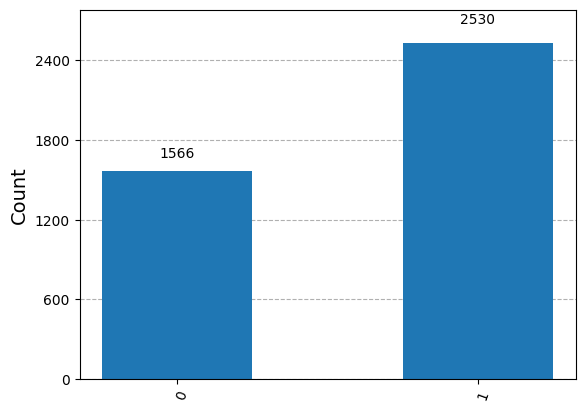

In [62]:
state3, result, _ = c2qa.util.simulate(circuit,shots = 4096)
plot_histogram(result.get_counts())

In [11]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [13]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qft(qc,2)
qc.measure_all()
sim_ideal = AerSimulator()
result1 = sim_ideal.run(qc).result()


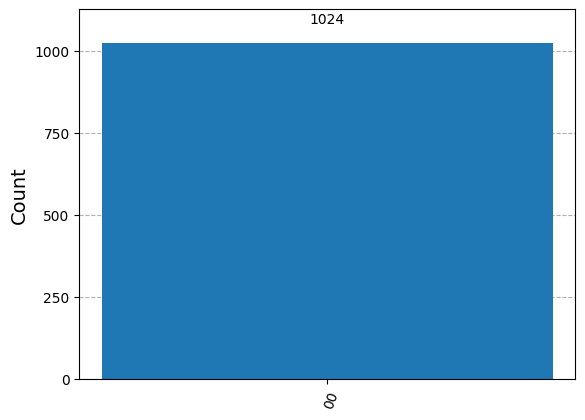

In [14]:
plot_histogram(result1.get_counts())

In [22]:
lmbda_list = np.arange(1,1.8,0.1)
for i in range(len(lmbda_list)):
    delta = lmbda_list[i]
    delta_prime = (2*np.pi)/(np.pow(2,n+ancilla+append)*delta)
    
    Ust = custom_gates.state_transfer.dv2cv_st_non_abelian(delta,n+ancilla+append,cutoff)
    Ust1 = custom_gates.state_transfer.dv2cv_st_non_abelian(delta_prime,n+append+ancilla,cutoff)
    F_gate = custom_gates.qft.F(cutoff)

    qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=3, name='qmode')
    qbr1 = QuantumRegister(n,name='qbits')
    ancilla_reg = QuantumRegister(ancilla,name = 'ancilla')
    append_reg = QuantumRegister(append, name='append')
    cr1 = ClassicalRegister(2, name='creg')
    circuit = c2qa.CVCircuit(qmr, append_reg, qbr1, ancilla_reg, cr1)

    # Combine append, qubits, and ancilla registers
    total_register = append_reg[:]+ qbr1[:] + ancilla_reg[:]

    # Initialization
    circuit.cv_initialize(0, qmr[0])
    circuit.h(ancilla_reg[0])
    # circuit.h(ancilla_reg[1])
    # circuit.h(ancilla_reg[2])
    # circuit.h(ancilla_reg[3])

    circuit.h(qbr1[0])
    circuit.h(qbr1[1])
    circuit.h(qbr1[2])
    circuit.h(qbr1[3])
    circuit.h(qbr1[4])
    circuit.barrier()

    # Basis transformation
    apply_basis_transformation(circuit, total_register)

    circuit.barrier()

    # CV gates and operations
    gate1 = UnitaryGate(Ust.full(), label='DVtoCV')
    circuit.append(gate1, qmr[:] + total_register)
    circuit.cv_d(delta / 2, qmr[0])

    gate2 = UnitaryGate(F_gate.full(), label='F')
    circuit.append(gate2, qmr[:])

    circuit.cv_d(-delta_prime / 2, qmr[0])

    gate3 = UnitaryGate(Ust1.dag().full(), label='CVtoDV')
    circuit.append(gate3, qmr[:] + total_register)

    circuit.barrier()

    # Reverse basis transformation
    apply_reverse_basis_transformation(circuit, total_register)

    circuit.barrier()

    # Measurements
    # for i, qubit in enumerate(total_register):
    #     if(i == 0 or i ==1):
    #         continue
    #     if(i>1 and i<=n+1):
    #         circuit.measure(qubit, cr1[-(i + 1)])
    circuit.measure(ancilla_reg[1], cr1[1])
    circuit.measure(ancilla_reg[0], cr1[0])

    state3, result, _ = c2qa.util.simulate(circuit,shots = 4096)

    qc = QuantumCircuit(5)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)
    qft(qc,5)
    qc.measure_all()
    sim_ideal = AerSimulator()
    result1 = sim_ideal.run(qc,shots = 4096).result()

    hell_fid = hellinger_fidelity(result.get_counts(),result1.get_counts())

    print(f'Fidelity for {delta} : {hell_fid}')

    


IndexError: list index out of range

In [16]:
print(lmbda_list)

[0.1]
